In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from sklearn import preprocessing
import math


In [ ]:
# Paths for dataset
uploaded_zip_path = "/content/orl_faces.zip"
extracted_path = "/content/dataset"
dataset_path = "/content/dataset"

# Extract the dataset
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Dataset extracted to: {extracted_path}")

Dataset extracted to: /content/dataset


In [ ]:
# Function to plot portraits/images
def plot_portraits(images, titles, h, w, n_row, n_col):
    fig, axes = plt.subplots(n_row, n_col, figsize=(2 * n_col, 2 * n_row))
    axes = axes.ravel()
    for i in range(n_row * n_col):
        axes[i].imshow(images[i].reshape((h, w)), cmap='gray')
        axes[i].set_title(titles[i], fontsize=8)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# To get the total number of images
total_images = 0
shape = (112, 92)
for folder in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, folder)):
        for image_file in os.listdir(os.path.join(dataset_path, folder)):
            if image_file.endswith('.pgm') or image_file.endswith('.jpg'):
                total_images += 1

print(f"Total number of images: {total_images}")


Total number of images: 400


In [ ]:
# Initialize the numpy array to hold all images
all_images = np.zeros((total_images, shape[0], shape[1]), dtype='float64')
names = []
i = 0

# Load all images into the numpy array
for folder in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, folder)):
        for _ in range(10):
            names.append(folder)
        for image_file in os.listdir(os.path.join(dataset_path, folder)):
            if image_file.endswith('.pgm') or image_file.endswith('.jpg'):
                image_path = os.path.join(dataset_path, folder, image_file)
                read_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                resized_image = cv2.resize(read_image, (shape[1], shape[0]))
                all_images[i] = resized_image
                i += 1


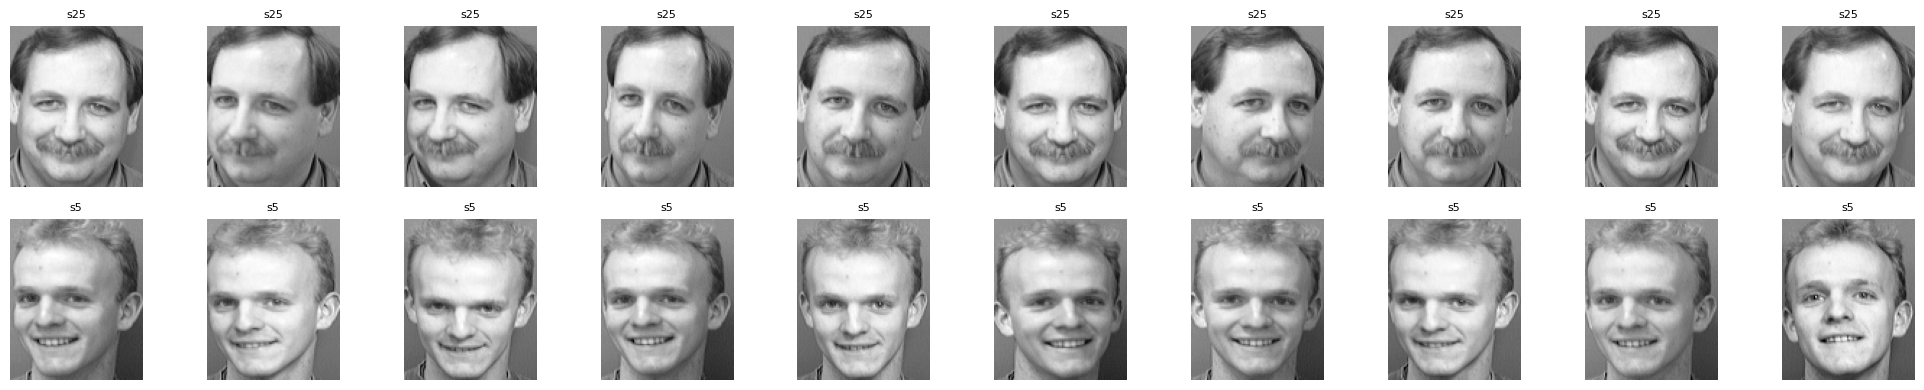

In [ ]:
# Plot some sample images from the dataset
plot_portraits(all_images, names, shape[0], shape[1], 2, 10)

In [ ]:
# Flatten the images (each row is an image vector)
A = np.reshape(all_images, (total_images, shape[0] * shape[1]))

In [ ]:
# Calculate the mean image
mean_vector = np.sum(A, axis=0, dtype='float64') / total_images
mean_matrix = np.tile(mean_vector, (total_images, 1)) #create a matrix of mean vector
A_tilde = A - mean_matrix  # Mean-subtracted image vectors

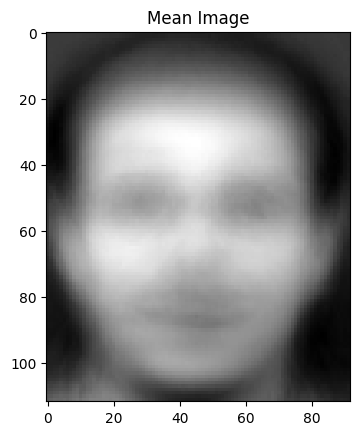

In [ ]:
# Plot mean image
plt.imshow(np.reshape(mean_vector, (shape[0], shape[1])), cmap='gray')
plt.title('Mean Image')
plt.show()

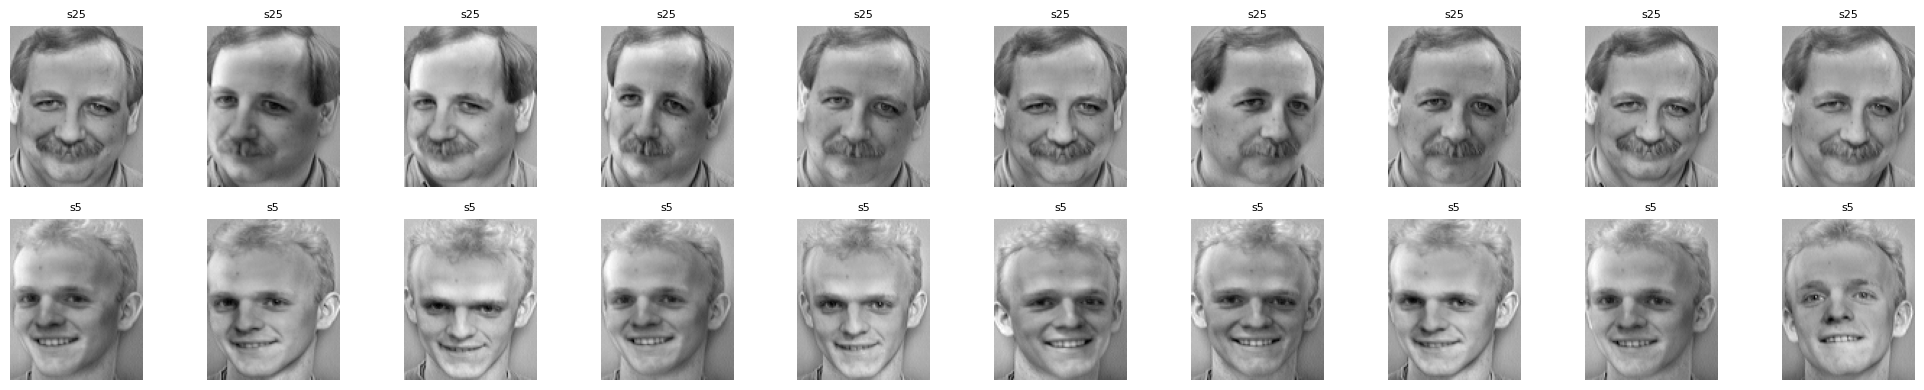

In [ ]:
# Plot the mean-subtracted images
plot_portraits(A_tilde, names, shape[0], shape[1], 2, 10)

In [ ]:
# Calculate the covariance matrix L
L = (A_tilde.dot(A_tilde.T)) / total_images
print("L shape: ", L.shape)

L shape:  (400, 400)


In [ ]:
# Eigen decomposition of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(L)
idx = eigenvalues.argsort()[::-1]  # Sort eigenvalues in descending order
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

In [ ]:
# Compute the eigenvectors of the original matrix A_tilde
eigenvectors_C = A_tilde.T.dot(eigenvectors)
eigenfaces = preprocessing.normalize(eigenvectors_C.T) #normalize the eigenfaces

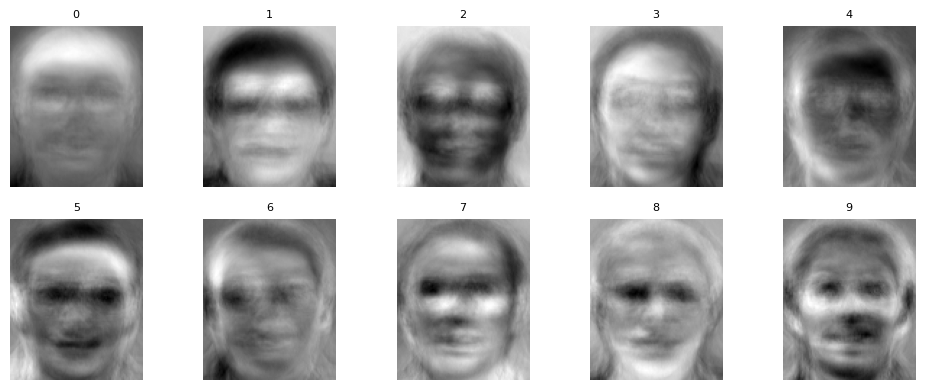

In [ ]:
# Plot the eigenfaces
num_eigenfaces_to_plot = 10
eigenfaces_to_plot = eigenfaces[:num_eigenfaces_to_plot]
plot_portraits(eigenfaces_to_plot, range(num_eigenfaces_to_plot), shape[0], shape[1], 2, 5)

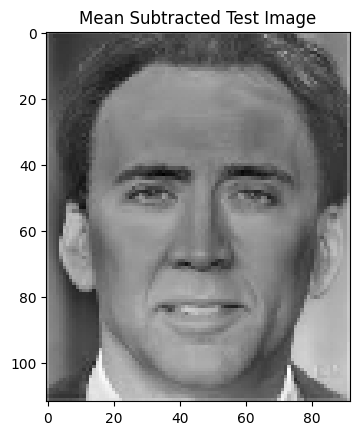

In [ ]:
# Process test image
test_img = cv2.imread('test.jpeg', cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (shape[1], shape[0]))
mean_subtracted_testimg = np.reshape(test_img, (test_img.shape[0] * test_img.shape[1])) - mean_vector
plt.imshow(np.reshape(mean_subtracted_testimg, (shape[0], shape[1])), cmap='gray')
plt.title("Mean Subtracted Test Image")
plt.show()

In [ ]:
# Choose the number of eigenfaces to use for projection
q = 350
omega = eigenfaces[:q].dot(mean_subtracted_testimg)


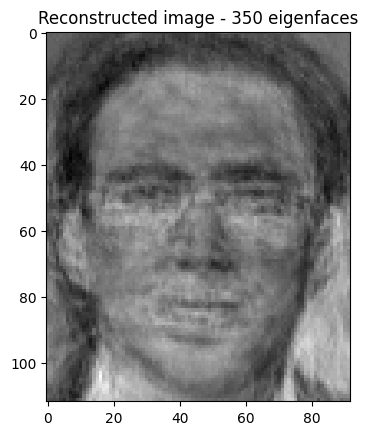

In [ ]:
# Reconstruct the image using the chosen eigenfaces
reconstructed = eigenfaces[:q].T.dot(omega)
plt.imshow(np.reshape(reconstructed, (shape[0], shape[1])), cmap='gray')
plt.title("Reconstructed image - " + str(q) + " eigenfaces")
plt.show()

In [ ]:
# Face detection using a threshold
alpha_1 = 3000
projected_new_img_vector = eigenfaces[:q].T.dot(omega)  # Project the test image onto the eigenfaces
diff = mean_subtracted_testimg - projected_new_img_vector
beta = math.sqrt(diff.dot(diff)) # Distance between the original face image vector and the projected vector
if beta < alpha_1:
    print("Face detected in the image with weights of:", beta)
else:
    print("No face detected in the image with weights of:", beta)


Face detected in the image! with weights of: 2011.0301308707735


In [ ]:
alpha_2 = 3000
smallest_value = None
index = None

for k in range(total_images):
    omega_k = eigenfaces[:q].dot(A_tilde[k])  # Project the images in the dataset onto the eigenfaces
    diff = omega - omega_k
    epsilon_k = math.sqrt(diff.dot(diff))

    if smallest_value is None or smallest_value > epsilon_k:
        smallest_value = epsilon_k
        index = k

if smallest_value < alpha_2:
    print(smallest_value, names[index])
else:
    print(smallest_value, "Unknown Face!")


4088.200079812568 Unknown Face!


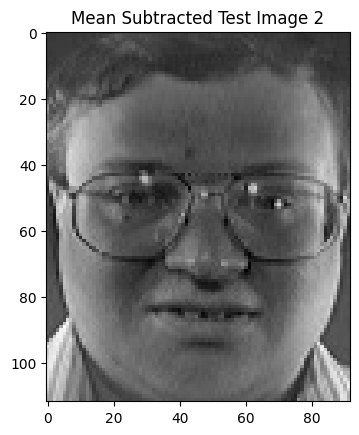

In [ ]:
test_img_2 = cv2.imread('test_2.jpg', cv2.IMREAD_GRAYSCALE)
test_img_2 = cv2.resize(test_img_2, (shape[1], shape[0]))
mean_subtracted_testimg_2 = np.reshape(test_img_2, (test_img_2.shape[0] * test_img_2.shape[1])) - mean_vector
plt.imshow(np.reshape(mean_subtracted_testimg_2, (shape[0], shape[1])), cmap='gray')
plt.title("Mean Subtracted Test Image 2")
plt.show()

omega_2 = eigenfaces[:q].dot(mean_subtracted_testimg_2)

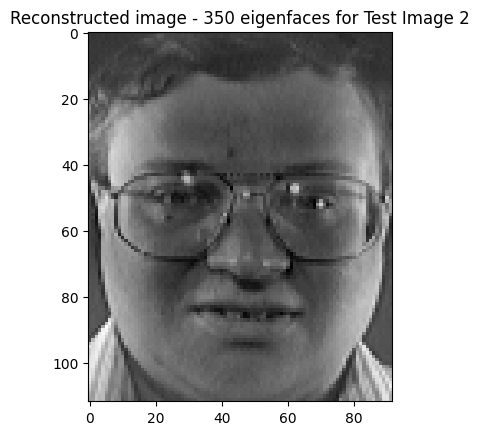

In [ ]:
reconstructed_2 = eigenfaces[:q].T.dot(omega_2)
plt.imshow(np.reshape(reconstructed_2, (shape[0], shape[1])), cmap='gray')
plt.title("Reconstructed image - " + str(q) + " eigenfaces for Test Image 2")
plt.show()

In [ ]:
alpha_1 = 3000
projected_new_img_vector_2 = eigenfaces[:q].T.dot(omega_2)
diff_2 = mean_subtracted_testimg_2 - projected_new_img_vector_2
beta_2 = math.sqrt(diff_2.dot(diff_2))

if beta_2 < alpha_1:
    print("Face detected in the image! ", beta_2)
else:
    print("No face detected in the image! ", beta_2)



Face detected in the image!  285.34186394957726


In [ ]:
alpha_2 = 3000
smallest_value_2 = None
index_2 = None

for k in range(total_images):
    omega_k_2 = eigenfaces[:q].dot(A_tilde[k])
    diff_2 = omega_2 - omega_k_2
    epsilon_k_2 = math.sqrt(diff_2.dot(diff_2))

    if smallest_value_2 is None or smallest_value_2 > epsilon_k_2:
        smallest_value_2 = epsilon_k_2
        index_2 = k

if smallest_value_2 < alpha_2:
    print(smallest_value_2, names[index_2])
else:
    print(smallest_value_2, "Unknown Face!")

24.01004673953623 s31
